# 第一节 线性回归
代码修改并注释：廖永,广东工业大学硕士在读,如有错误或指正,请联系136884000@qq.com  
代码运行环境：python3.7
安装TensorFlow的方法：pip install tensorflow
附pandas常用功能函数网址：https://blog.csdn.net/weixin_41770169/article/details/79539232

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot是一些命令行风格函数的集合，使matplotlib以类似于MATLAB的方式工作。
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep")

In [21]:
A=np.eye(5)    #单位对角矩阵
print(A)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [19]:
df = pd.read_csv('ex1data1.txt',names=['人口','利润'])    # header = None表示没有表头
#需要注意的是，Jupyter notebook只能打开当前目录下的数据集，如csv，所以需要使用upload把数据集倒导入到当前目录下。           
#pd.read_csv的作用是将csv文件读入并转化为数据框形式，有非常多的参数，用到时可查阅文档。



In [20]:
df.head() #读前5行
#括号内可填写要读取的前n行，如果不填，默认为n=5

,人口,利润
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [22]:
df.info() #查看索引、数据类型和内存信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   人口      97 non-null     float64
 1   利润      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


*****
# 通过绘制散点图来观察原始数据

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21033 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib

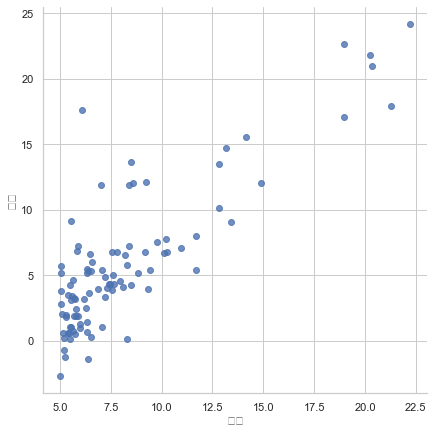

In [23]:
sns.lmplot('人口','利润',data=df,size=6,fit_reg = False)
#fit_reg:拟合回归参数,如果fit_reg=True则散点图中则出现拟合直线
plt.show()


***
# 计算代价函数

首先，我们将创建一个以参数θ为特征函数的代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [13]:
def computeCost (X,y,theta):
    inner=np.power((X*theta.T)-y,2)  
    #theta.T就是矩阵theta的转置矩阵
    #np.power(A,B)   ## 对A中的每个元素求B次方
    return np.sum(inner)/(2*len(X))

让我们在数据中添加了一列，以便我们可以使用向量化的解决方案来计算代价和梯度。

In [24]:
df.insert(0,'ONE',1)  #在第0列插入表头为“ONE”的列，数值为1

下面对变量进行初始化

In [25]:
#设置训练值变量X和目标变量y
cols=df.shape[1] #获取表格df的列数
X=df.iloc[:,0:cols-1] #除最后一列外，取其他列的所有行，即X为O和人口组成的列表
y=df.iloc[:,cols-1:cols]#取最后一列的所有行，即y为利润


观察一下X和y是否正确

In [26]:
X.head()#看X的前5行

,ONE,人口
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [27]:
y.head()#看y的前5行

,利润
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


代价函数是应该是numpy矩阵，所以我们需要转换X和Y，然后才能使用它们。 我们还需要初始化theta。

In [28]:
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

In [29]:
theta

matrix([[0, 0]])

In [30]:
X.shape,y.shape,theta.shape

((97, 2), (97, 1), (1, 2))

计算代价函数 (theta初始值为0).

In [31]:
computeCost (X,y,theta)

32.072733877455676

# batch gradient decent（批量梯度下降）对应笔记P21页
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [35]:
def gradientDescent(X,y,theta,alpha,iters):      #alpha是学习率,iters为迭代次数
    temp=np.matrix(np.zeros(theta.shape)) #np.zeros(theta.shape)=[0.,0.],然后将temp变为矩阵[0.,0.]
    parameters= int(theta.ravel().shape[1])  
    #theta.ravel()：将多维数组theta降为一维，.shape[1]是统计这个一维数组有多少个元
    #parameters表示参数
    cost=np.zeros(iters)     #初始化代价函数值为0数组，元素个数为迭代次数
    
    for i in range(iters):   #循环iters次
        error=(X*theta.T)-y
        
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])  #将误差与训练数据相乘，term为偏导数，参考笔记P27
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term)) #更新theta
        
        
        theta=temp
        cost[i] = computeCost(X,y,theta)  #计算每一次的代价函数
           
    return theta,cost

        
        
        


初始化一些附加变量,比如学习速率α和要执行的迭代次数。

In [32]:
alpha=0.01
iters=1500

现在让我们运行梯度下降算法来将我们的参数θ适合于训练集。

In [36]:
g, cost = gradientDescent(X, y, theta, alpha, iters) #令g和cost分别等于函数的两个返回值

看一下g

In [37]:
g

matrix([[-3.63029144,  1.16636235]])

看一下代价函数cost

In [38]:
cost

array([6.73719046, 5.93159357, 5.90115471, ..., 4.48343473, 4.48341145,
       4.48338826])

最后，我们可以使用我们拟合的参数计算训练模型的代价函数（误差）。

In [39]:
computeCost(X, y, g)  #最小化的低价函数

4.483388256587726

现在我们来绘制线性模型以及数据，直观地看出它的拟合。

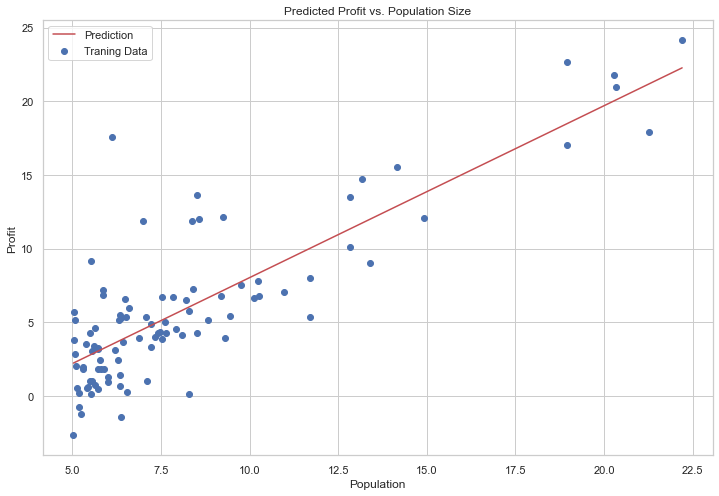

In [40]:
x = np.linspace(df.人口.min(),df.人口.max(),100)#以人口最小值为起点，最大值为终点，创建元素个数为100的等差数列
f = g[0,0] + (g[0,1] * x) #f是假设函数H

fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.plot(x, f, 'r', label='Prediction')   #设置点的横坐标，纵坐标，用红色线，并且设置Prediction为关键字参数
ax.scatter(df.人口, df.利润, label='Traning Data')  #以人口为横坐标，利润为纵坐标并且设置Traning Data为关键字参数
ax.legend(loc=2)  #legend为显示图例函数，loc为设置图例显示的位置，loc=2即在左上方
ax.set_xlabel('Population')  #设置x轴变量
ax.set_ylabel('Profit')  #设置x轴变量
ax.set_title('Predicted Profit vs. Population Size') #设置表头
plt.show()

由于梯度方程式函数也在每个训练迭代中输出一个代价的向量，所以我们也可以绘制。 请注意，代价总是降低 - 这是凸优化问题的一个例子。

***
# visualize cost data（代价数据可视化）

In [41]:
ax=sns.tsplot(data=cost,err_style='ci_band',interpolate=False,ci=[10,50,90],n_boot=iters)  #函数参数解释见笔记
ax.set_xlabel("inters")
ax.set_ylabel("cost")
plt.show()

AttributeError: module 'seaborn' has no attribute 'tsplot'

另一种调库方式

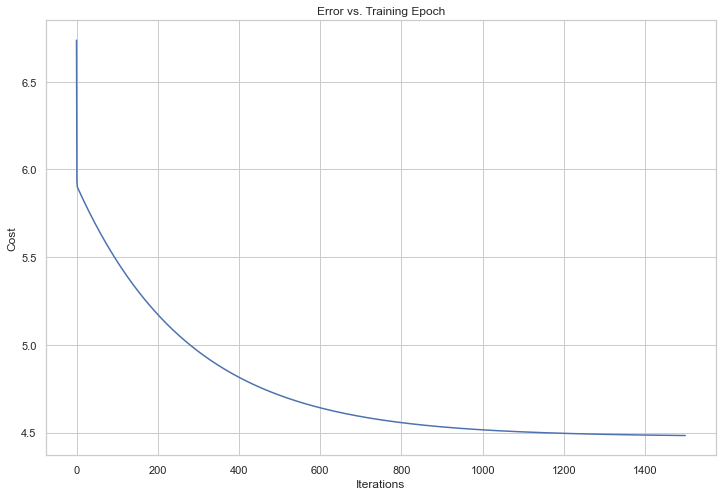

In [42]:
fig, ax = plt.subplots(figsize=(12,8)) #以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.plot(np.arange(iters), cost, 'b') #作图:以迭代次数为x，代价函数值为y,线条颜色为红色
ax.set_xlabel('Iterations')  #设置x轴变量
ax.set_ylabel('Cost')  #设置y轴变量
ax.set_title('Error vs. Training Epoch') #设置表头
plt.show()

## 第四章 多变量线性

### 多维特征

In [43]:
data2= pd.read_csv('ex1data2.txt',names=['square','bedrooms','price']) 
data2.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ex1data2.txt'

### 特征缩放
公式：
$$
x_{n}=\frac{x_{n}-\mu_{n}}{s_{n}}
$$
其中un是平均值，sn 是标准差。

In [ ]:
data2 = (data2 - data2.mean()) / data2.std()
data2.head()

现在我们重复第1部分的预处理步骤，并对新数据集运行线性回归程序。

In [ ]:
# add ones column
data2.insert(0, 'Ones', 1)#在第0列插入表头为“ONE”的列，数值为1

# set X (training data) and y (target variable)
cols = data2.shape[1]  #获取表格df的列数
X2 = data2.iloc[:,0:cols-1]#除最后一列外，取其他列的所有行，即X2为O，面积，卧室数组成的列表
y2 = data2.iloc[:,cols-1:cols]#取最后一列的所有行，即y2为利润

# convert to matrices and initialize theta
X2 = np.matrix(X2.values)  #转换为矩阵
y2 = np.matrix(y2.values)  #转换为矩阵
theta2 = np.matrix(np.array([0,0,0]))

# perform linear regression on the data set
g2, cost2 = gradientDescent(X2, y2, theta2, alpha, iters)

# get the cost (error) of the model
computeCost(X2, y2, g2)   #计算代价函数


我们也可以快速查看这一个的训练进程。

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.plot(np.arange(iters), cost2, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')
plt.show()

我们也可以使用scikit-learn的线性回归函数，而不是从头开始实现这些算法。 我们将scikit-learn的线性回归算法应用于第1部分的数据，并看看它的表现。

In [ ]:
from sklearn import linear_model  #从sklearn库中引入线性模块 
model = linear_model.LinearRegression()  #声明对象为线性回归模型
model.fit(X, y)           #拟合X,y

scikit-learn model的预测表现

In [ ]:
x = np.array(X[:, 1].A1)
f = model.predict(X).flatten() #将model.predict(X)中的数据降为一维，并返回源数据的副本

fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.plot(x, f, 'r', label='Prediction')   #设置点的横坐标，纵坐标，用红色线，并且设置Prediction为关键字参数
ax.scatter(df.人口, df.利润, label='Traning Data')  #以人口为横坐标，利润为纵坐标并且设置Traning Data为关键字参数
ax.legend(loc=2)  #legend为显示图例函数，loc为设置图例显示的位置，loc=2即在左上方
ax.set_xlabel('Population')  #设置x轴变量
ax.set_ylabel('Profit')  #设置x轴变量
ax.set_title('Predicted Profit vs. Population Size') #设置表头
plt.show()

# 学习率

In [ ]:
base = np.logspace(-5, -1, num=4)  #以10的-5次方为起点，10的-5次方为终点，元素数目为4的等比数列
candidate = np.sort(np.concatenate((base, base*3))) #将base和base*3两个数组拼接在一起，并将其排序
print(candidate)

# 4. normal equation（正规方程）
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型	

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型

In [ ]:
# 正规方程
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y#X.T@X等价于X.T.dot(X)  .dot()表示点积，也就是矩阵相乘的意思
    return theta

In [ ]:
final_theta2=normalEqn(X, y)#感觉和批量梯度下降的theta的值有点差距
final_theta2

梯度下降为matrix([[-3.63029144,  1.16636235]])